In [ ]:
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf
import math
import h5py
import matplotlib.pyplot as plt
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.regularizers import l2
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
def load_data():

	
	train_dataset = h5py.File("/content/drive/My Drive/Colab Notebooks/f.hdf5", mode="r")
	train_set_x_orig = np.array(train_dataset["train_img"][:]) 
	train_set_y_orig = np.array(train_dataset["train_labels"][:]) # your train set labels
	
	test_set_x_orig = np.array(train_dataset["test_img"][:]) # your test set features
	test_set_y_orig = np.array(train_dataset["test_labels"][:]) # your test set labels
   # classes = np.array(test_dataset["list_classes"][:]) # the list of classes
	train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
	test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
	return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

In [ ]:
def convert_to_one_hot(labels,c):
  c=tf.constant(c,name="c")
  one_hot_matrix=tf.one_hot(labels,c,axis=1)
  sess=tf.Session()
  one_hot=sess.run(one_hot_matrix)
  sess.close()
  return one_hot

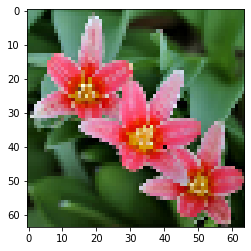

y = 2. It's a  picture.
(2029,)
[0 0 2 ... 2 1 2]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]
(2029, 3)


In [ ]:
train_x_orig,train_y,test_x_orig,test_y=load_data()

index=16
plt.imshow(train_x_orig[index])
plt.show()
print ("y = " + str(train_y[0,index]) + ". It's a " +  " picture.")
train_y=train_y[0,:]
test_y=test_y[0,:]
print(train_y.shape)
print(train_y)
train_y=convert_to_one_hot(train_y.T,3)
test_y=convert_to_one_hot(test_y.T,3)
print(train_y)
print(train_y.shape)

In [ ]:
def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
  m=X.shape[0]
  mini_batches=[]
  permutation=list(np.random.permutation(m))
  shuffled_X = X[permutation,:,:,:]
  shuffled_Y = Y[permutation,:]
  num_complete_minibatches=math.floor(m/mini_batch_size)
  for k in range(0,num_complete_minibatches):
    minibatch_X=shuffled_X[k*mini_batch_size:(k+1)*mini_batch_size,:,:,:]
    minibatch_Y=shuffled_Y[k*mini_batch_size:(k+1)*mini_batch_size,:]
    minibatch=(minibatch_X,minibatch_Y)
    mini_batches.append(minibatch)
  if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

  return mini_batches

The following implemention uses res nets which  comprises of identity and convolutional block. 
The **identity block** is where the input layer dimension(a[l]) is same as output layer dimension(a[l+2]). There are 3 componenets in this block: 1st component contains conv layer-->batch normalisation(channel)-->relu activation. 2nd component contains conv-->batch_norm-->relu. 3rd layer contains conv-->batch_norm-->add input to 1st component--> relu

The convolutional block contains 3 components: 1st component contains conv-->batch_norm-->relu .2nd component contains conv-->batchnorm-->relu. 3rd component contains conv-->batch_norm-->modify shape of input to first componet the add-->relu

In [ ]:
def identity_block(X,f,filters,stage,block):
  conv_name_base="res"+str(stage)+block+"_branch"
  bn_name_base="bn"+str(stage)+block+"_branch"
  F1,F2,F3=filters
  X_shortcut=X

  ###component1##

  X=Conv2D(F1,kernel_size=(1,1),strides=(1,1),padding="valid",name=conv_name_base+"2a",kernel_initializer=glorot_uniform(seed=0),bias_regularizer=l2(0.001))(X)
  X=BatchNormalization(axis=3,name=bn_name_base+"2a")(X)
  X=Activation("relu")(X)

  ##component2
  X=Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding="same",name=conv_name_base+"2b",kernel_initializer=glorot_uniform(seed=0),bias_regularizer=l2(0.001))(X)
  X=BatchNormalization(axis=3,name=bn_name_base+"2b")(X)
  X=Activation("relu")(X)

  ##comp 3

  X=Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding="valid",name=conv_name_base+"2c",kernel_initializer=glorot_uniform(seed=0))(X)
  X=BatchNormalization(axis=3,name=bn_name_base+"2c")(X)

  X=Add()([X,X_shortcut])
  X=Activation("relu")(X)

  return X


In [ ]:
def convolutional_block(X,f,filters,stage,block,s=2):
  conv_name_base="res"+str(stage)+block+"_branch"
  bn_name_base="bn"+str(stage)+block+"_branch"
  F1, F2, F3 = filters
  X_shortcut=X

  ##1st component
  X = Conv2D(F1, (1, 1), strides = (s,s),padding="valid", name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0),bias_regularizer=l2(0.001))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)

  ##2nd component

  X=Conv2D(F2,(f,f),strides=(1,1),padding="same",name=conv_name_base+"2b",kernel_initializer=glorot_uniform(seed=0),bias_regularizer=l2(0.001))(X)
  X=BatchNormalization(axis=3,name=bn_name_base+"2b")(X)
  X=Activation("relu")(X)

  ##3rd component
  X=Conv2D(F3,kernel_size=(1,1),strides=(1,1),padding="valid",name=conv_name_base+"2c",kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
  
  X_shortcut = Conv2D(F3, (1, 1), strides = (s,s),padding="valid", name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
  X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

  X = Add()([X,X_shortcut])
  X =  Activation('relu')(X)
  return X


In [ ]:

def ResNet50(input_shape = (64, 64, 3), classes = 3):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X =  identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X =identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    
    X = AveragePooling2D((2,2),name="avg_pool")(X)
    
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0),bias_regularizer=l2(0.01))(X)
    
    
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape = (64, 64, 3), classes = 3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_x_orig, train_y, epochs = 21, batch_size = 64)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Epoch 1/21
2029/2029 [==============================] - 14s 7ms/step - loss: 2.0418 - accuracy: 0.4204
Epoch 2/21
2029/2029 [==============================] - 3s 1ms/step - loss: 0.9982 - accuracy: 0.5954
Epoch 3/21
2029/2029 [==============================] - 2s 1ms/step - loss: 0.9337 - accuracy: 0.6230
Epoch 4/21
2029/2029 [==============================] - 2s 1ms/step - loss: 0.8253 - accuracy: 0.6432
Epoch 5/21
2029/2029 [==============================] - 2s 1ms/step - loss: 0.6786 - accuracy: 0.7270
Epoch 6/21
2029/2029 [==============================] - 2s 1ms/step - loss: 0.5899 - accuracy: 0.7748
Epoch 7/21
2029/2029 [==============================] - 2s 1ms/step - loss: 0.5649 - accuracy: 0.7866
Epoch 8/21
2029/2029 [==============================] - 3s 1ms/step - loss: 0.4508 - accuracy: 0.8255
Epoch 9/21
2029/2029 [==============================] - 2s 1ms/step - loss: 0.3622 - accuracy: 0.86

In [ ]:
preds = model.evaluate(test_x_orig, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

508/508 [==============================] - 1s 2ms/step
Loss = 1.182169406432805
Test Accuracy = 0.5905511975288391
